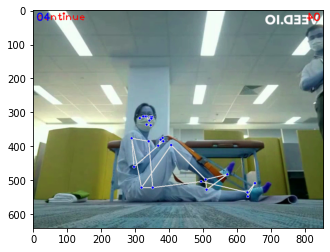

In [4]:
from ast import Str
import math
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
mp_pose = mp.solutions.pose

# setting the parameter for the pose detection
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils 
# this function will set landmarks on the image and return the coordinates of landmark and final marked image
def detectPose(image, pose, display=True):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    results = pose.process(imageRGB)
    height, width, _ = image.shape
    landmarks = []
    
    if results.pose_landmarks:
    
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    if display:
    
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        # to get the image of pose in a 3-d plane
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    else:
        
        return output_image, landmarks
# this function will calculate the angle between the three pts-ankle,knee and hip
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))    
    if angle < 0:
        angle += 360    
    return angle
# this function will  put the condition on how much angle will start coundown
def classifyPose(landmarks, output_image, display=False):
   

    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    label = 'continue'
                
    # if angle is b/w [210,325] we will start the coundown
    if (right_knee_angle > 210 and right_knee_angle < 325) or (left_knee_angle > 210 and left_knee_angle < 325):    
        cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)
                # to get the real time angle add this
                    # label=str(right_knee_angle)
                    # cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,period,(10,30), font, 1,(0,0,255),2,cv2.LINE_AA)
        
    # if angle dont fulfill the required angle we will show feedback
    else:
        label='\b keep your knee bent'
        sec=0
        cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)
      
    
    
    if display:
    
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        return output_image, label

pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# capturing the video-put your video here
video_path='KneeBendVideo.mp4'
cap = cv2.VideoCapture(video_path)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

fps = 0
if int(major_ver)  < 3 :
    fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = cap.get(cv2.CAP_PROP_FPS)
sec = 0
period = '00'
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('outpuutttt.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))




while cap.isOpened():
    ok, frame = cap.read()
    # print("captured_frame")
    # setting the timer
    if ok==True:    
        cfn = cap.get(1)
        if int(cfn)%int(fps)==0:
            if sec > 8:
                sec = 0

            period = "{:02d}".format(sec)
            sec = sec + 1

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,period,(10,30), font, 1,(255,0,0),2,cv2.LINE_AA)
        frame = cv2.flip(frame, 1)
        
        frame_height, frame_width, _ =  frame.shape
        
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
        
        # getting the landmarked frame 
        frame, landmarks = detectPose(frame, pose, display=False)
        
        if landmarks:
            
            frame, _ = classifyPose(landmarks, frame, display=False)
        
        cv2.imshow('frame',frame)
        plt.imshow(frame)
        # writing the frame into the video
        out.write(frame)

        key = cv2.waitKey(1) & 0xFF
        # if q is pressed video reading is stopped
        if key == ord("q"):
            
            break

cap.release()
cv2.destroyAllWindows()